#Treinando e avaliando Árvores de Decisão e Redes Neurais em dados de tumores da mama

https://www.kaggle.com/paultimothymooney/predicting-breast-cancer-from-nuclear-shape

https://medium.com/analytics-vidhya/creating-a-machine-learning-model-to-predict-malignant-breast-cancer-tumors-87abc4065432

https://scikit-learn.org/stable/modules/tree.html

O núcleo é uma organela presente em todas as células eucarióticas, incluindo células humanas. A forma nuclear irregular pode ser usada para identificar células cancerígenas. Artigos científicos sugerem que há alguma conexão entre a forma do núcleo e os estados de doenças humanas, como câncer e envelhecimento. Como tal, a análise quantitativa do tamanho e forma nuclear tem importantes aplicações biomédicas.

Técnicos podem usar um microscópio para observar amostras de tecido que foram retiradas de pacientes com suspeita de câncer de mama. Observando o tamanho e a forma dos núcleos presentes nessas amostras de tecido, os médicos podem determinar se uma determinada amostra parece ser benigna ("B") ou maligna ("M"). Seria bom ter um método automatizado que possa determinar rapidamente se uma amostra é benigna ou maligna. Neste notebook é demonstrado o uso de árvore de decisão e uma rede neural multicapara para prever a classe de uma amostra de tecido, dadas as medidas dos núcleos das células encontradas.


##Setup

First, we must setup our environment. We import various libraries (which you can view in the code cell below) and setup our directories according to the result we get from walking the filenames in our supplied files.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # splitting our data into training and testing data
import seaborn as sns # for creating a correlation heatmap
import matplotlib.pyplot as plt # for displaying our heatmap for analysis
from sklearn.metrics import accuracy_score # to score our model
from sklearn import tree
from sklearn.neural_network import MLPClassifier

# Input data files are available in the "../input/" directory.

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


##Reading our Data

Here, we read our data from the supplied .csv file using Pandas and representing it as a Pandas dataframe.

We are interested in predicting a diagnosis based on cell features, so we assign a 'y' variable to the diagnosis column.

It is worth noting that when using the 'id' feature as an index col, we get a column full of NaN entries. We remove this column as it provides no use to us. We also change some Pandas options. This is intended so that whenever we call 'head', we can see all the features and column names without truncation.

We then replace the diagnoses with 1 for malignant (original represented as an 'M') and 0 for benign (originally represented as a 'B'). This is useful for when we fit our model.


In [ ]:
X_full = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data.csv', index_col='id')

# Assign y to the diagnosis column
y = X_full.diagnosis

# Assigning our index_col to be the column 'id' shifted our data over, leaving a column with all NaN entries.
# We drop that here
X = X_full.drop(columns=['Unnamed: 32'])

# Show all values whenever we call head.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# If we run .dtypes on our data frame, we notice that all columns, aside from the diagnosis being a string, our integers.

# We replace a malignant diagnosis with 1, and benign with 0
X['diagnosis'].replace('M', 1, inplace=True)
X['diagnosis'].replace('B', 0, inplace=True)
y.replace('M', 1, inplace=True)
y.replace('B', 0, inplace=True)

print(X.shape)
print(569*31)
print(sum(y))

(569, 31)
17639
212



##Data Analysis

To avoide overfitting, we find the features which seem to have a low impact on the diagnosis. We do this by using a heatmap correlation chart.

The figure we get will display the correlation one attribute has on another. We are interested in which attributes do (or don't) affect the diagnosis column. We analyze the results on the figure, and ignore the features which have less than an absolute value of 0.5.


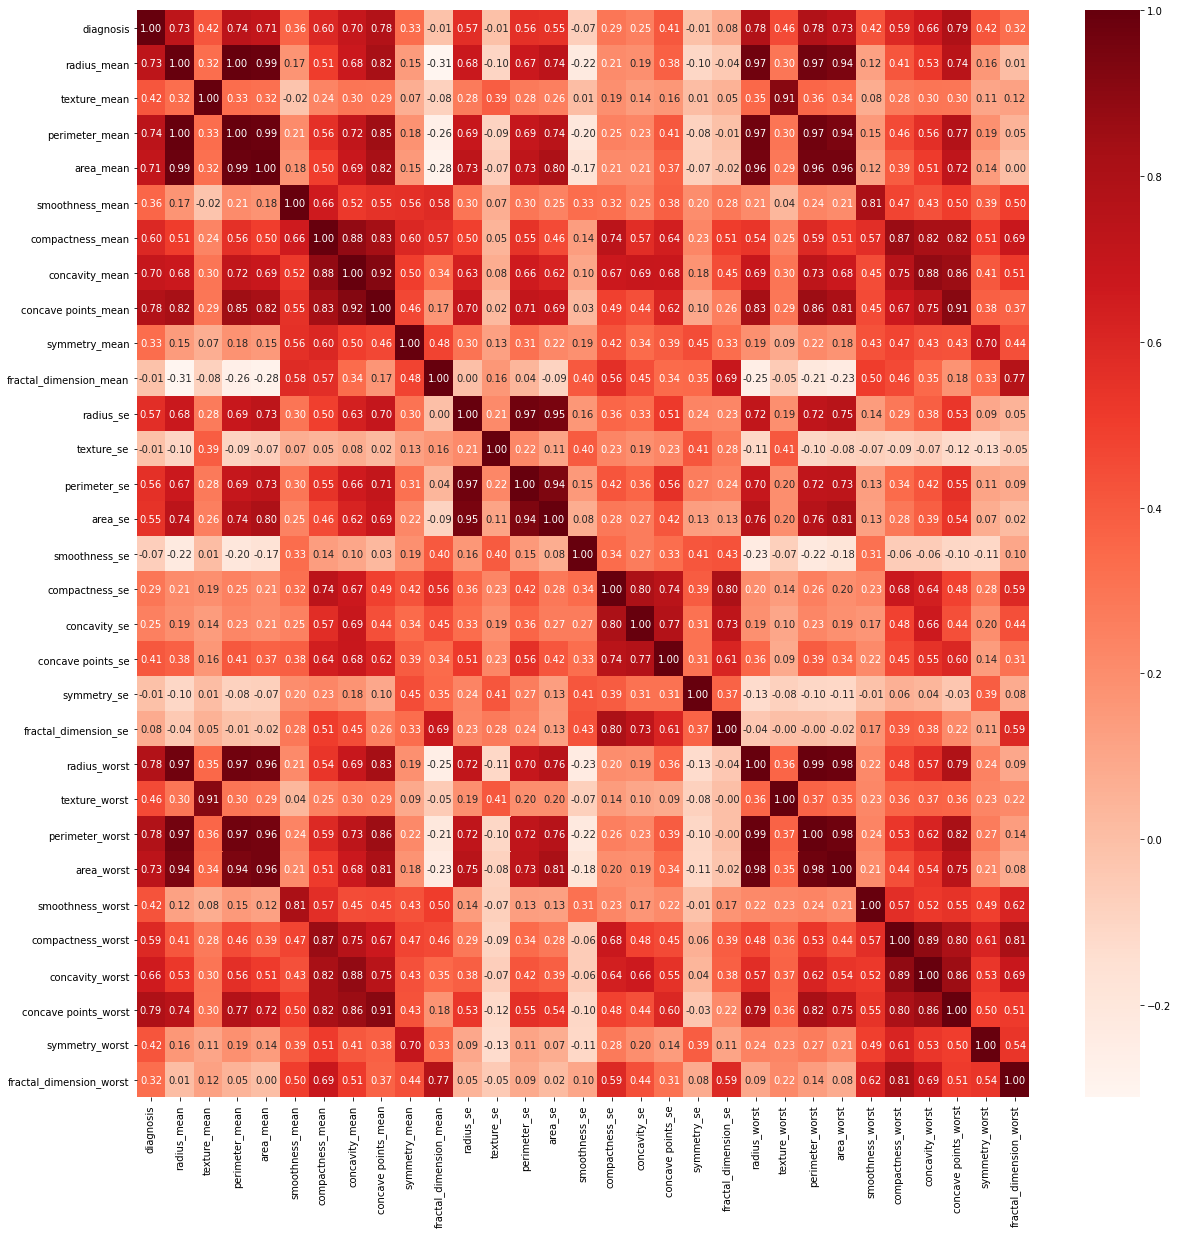

In [ ]:
# Here, we use the seaborn correlation heatmap to visualize the correlatons of features in our dataset on one another.
# Using the filter method, we will drop features which have an absolute value of less than 0.5 on the feature 'diagnosis'

# Setting up and displaying our heatmap correlation
plt.figure(figsize=(20,20))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt='.2f')
plt.show()


##Applying our Analysis

Now, we run some code to do exactly what we said we would do above: ignore the features which have a low impact on the diagnosis column.

We also split our data into training and testing data to both train and fit our model.


In [ ]:
# Keep features which have a med-high correlation on the diagnosis
features = ['radius_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concavity_mean', 
            'concave points_mean', 'radius_se', 'perimeter_se', 'area_se', 'radius_worst', 'perimeter_worst',
           'area_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst']
X = X[features]

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

In [ ]:
X_train.shape

(455, 15)


##Creating and Testing a Model

Now we are ready to create, train, and test a model. We must use a classifying model, as the predictions are to either be a 0 (for benign) and 1 (for malignant). We assess the accuracy of this model using SKLearn's "accuracy_score" function.


In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
preds = clf.predict(X_valid)
accuracy_score(y_valid, preds)



0.9385964912280702

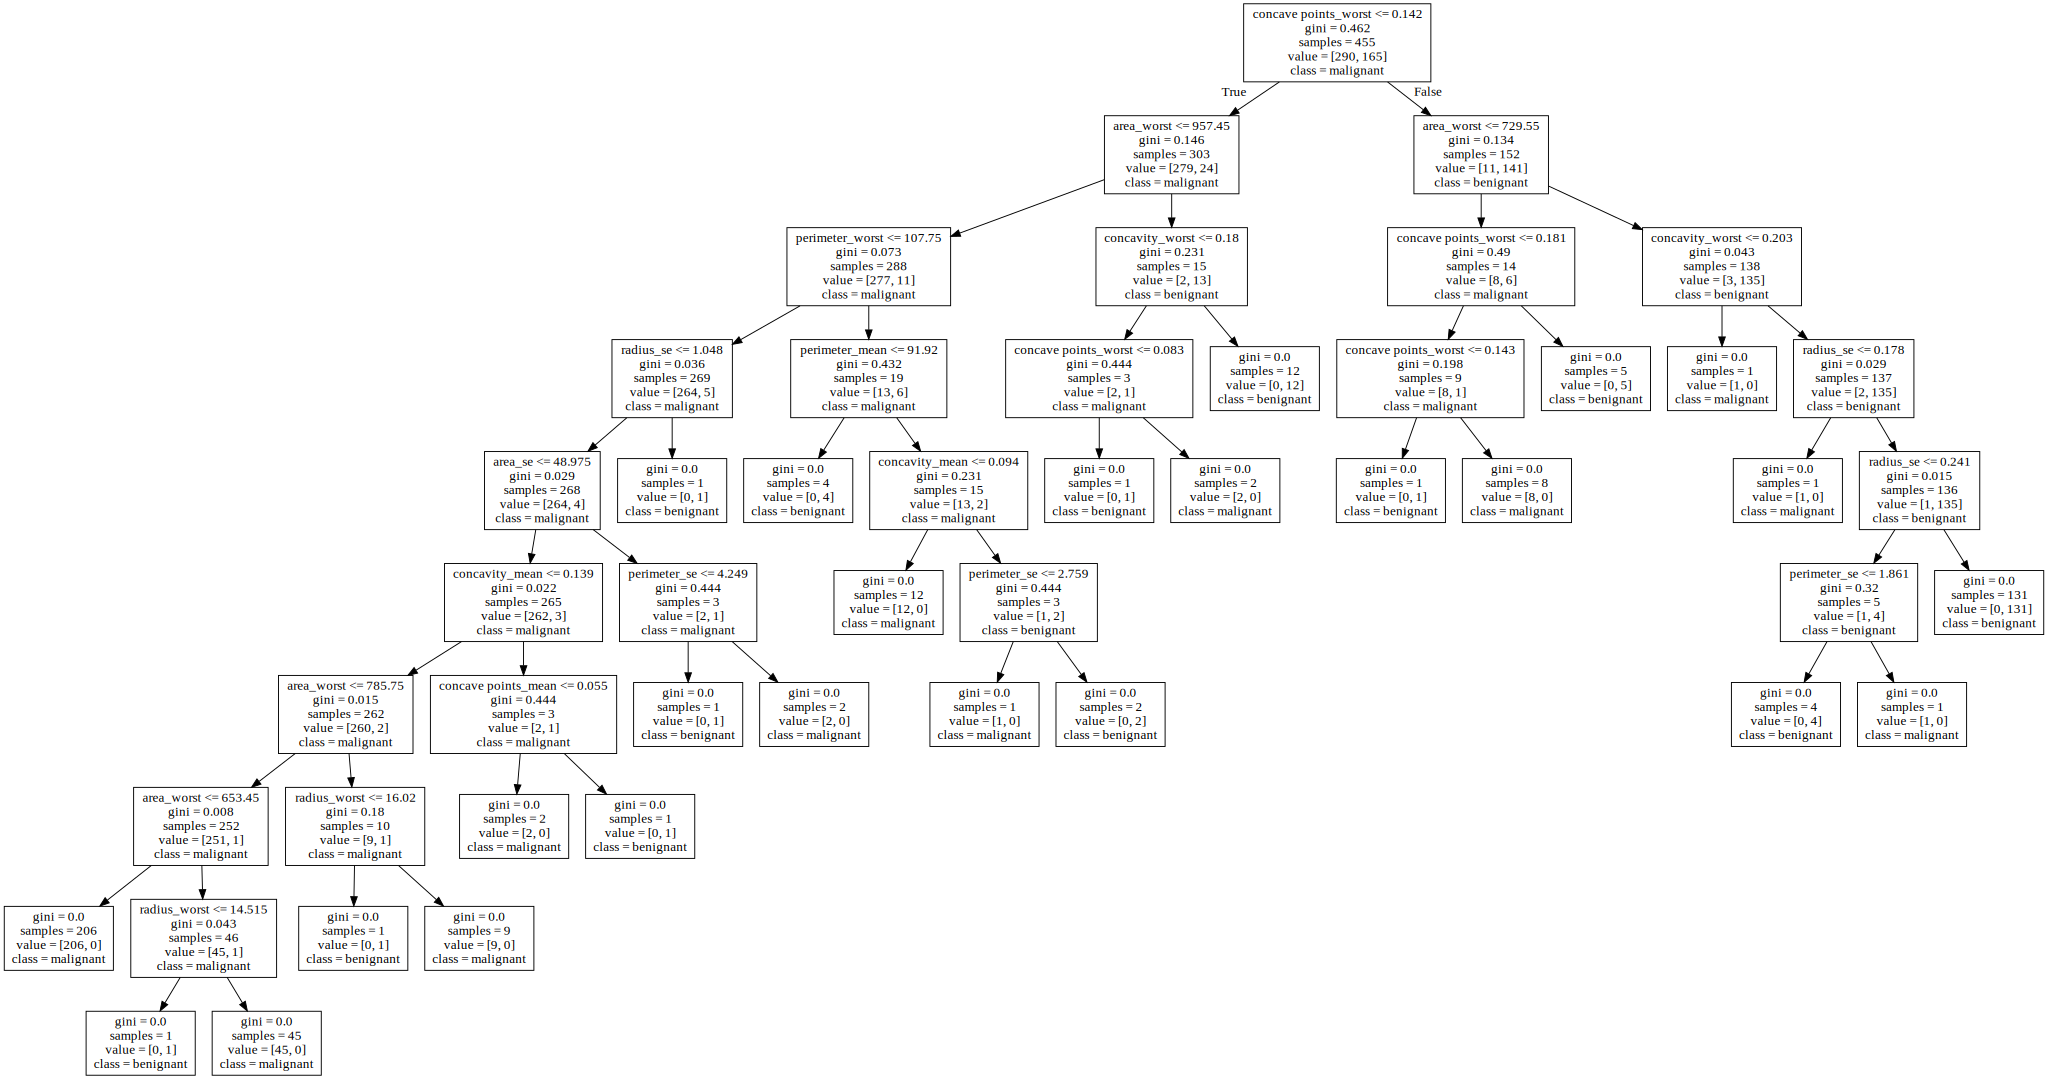

In [ ]:
classes=['malignant', 'benignant']
import graphviz 
dot_data = tree.export_graphviz(clf, feature_names=features, class_names=classes, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  # doctest: +SKIP
# Don't cheat - fit only on training data
scaler.fit(X_train)  # doctest: +SKIP
X_train = scaler.transform(X_train)  # doctest: +SKIP
scaler.fit(X_valid)  # doctest: +SKIP
X_valid = scaler.transform(X_valid)  # doctest: +SKIP

0.9385964912280702

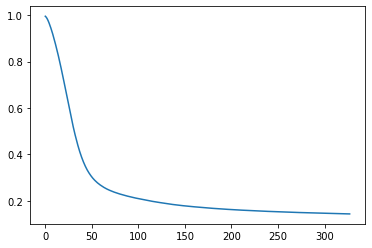

In [ ]:

clf2 = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(15,2), max_iter=1000, n_iter_no_change=10, random_state=1)
scaler = StandardScaler()

clf2 = clf2.fit(X_train, y_train)
plt.plot(clf2.loss_curve_)
preds2 = clf2.predict(X_valid)
accuracy_score(y_valid, preds2)

# **Agora é a sua vez**

# **1) Por que será que a rede neural desempenhou de forma tão inferior à Árvore de Decisão? Será que há algo errado com os dados de treinamento? Consulte https://scikit-learn.org/stable/modules/neural_networks_supervised.html e verifique se está tudo certo no código acima, corrigindo eventuais problemas e verificando o novo escore de acurácia obtido.**

O modelo do tipo MLP é extremamente sensível ao *feature scaling*, por isso a documentação recomenda aplicar uma transformação nos dados de modo que eles encontrem-se na faixa de [-1,1]. Para tanto, aplicou-se aos dados de treinamento e validação as funções pertencentes à classe StandardScaler, que subtrai o valor referente da média da coluna e divide pelo desvio padrão. Como pode-se observar, o resultado foi bem mais próximo do outro modelo, atingindo quase 93% de acurácia. 


# **2) Leia a documentação em https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html e adicione código para imprimir matrizes de confusão para os 2 classificadores criados anteriormente. Quais as confusões mais frequêntes para cada classificador avaliado?**


In [ ]:
from sklearn.metrics import confusion_matrix

neural_conf_matrix = confusion_matrix(y_valid, preds)
decision_tree_conf_matrix = confusion_matrix(y_valid, preds2)
neural_conf_matrix

array([[63,  4],
       [ 3, 44]])

In [ ]:
decision_tree_conf_matrix

array([[64,  3],
       [ 4, 43]])

O que pode-se observar é que as diagonais de ambas as matrizes de confusão indicam que os modelos tem um comportamento bastante satisfatório. Esses valores mais frequentes representam os Verdadeiros Positivos e os Falsos Positivos, indicando que os modelos tem uma boa acurácia.

# **3) Altere a arquitetura de sua rede neural, criando pelo menos 3 variantes com mais e com menos neurônios na camada escondida e analise os resultados obtidos em termos de acurácia no conjunto de validação. É possível tirar alguma conclusão a partir destes resultados?**

In [ ]:
import numpy as np

scaler = StandardScaler()
accuracy = []
clf_models = []
preds = []
for n_layers in np.array([1,2,3,6,9]):
  clf_models.append(MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(15,n_layers), max_iter=1000, n_iter_no_change=10, random_state=1))

for model in range(len(clf_models)):
  clf_models[model] = clf_models[model].fit(X_train,y_train)
  preds.append(clf_models[model].predict(X_valid))
  accuracy.append(accuracy_score(y_valid,preds[model]))

dt = {'Número de Camadas Ocultas':[1,2,3,6,9],'Acurácia':accuracy}
df = pd.DataFrame(dt)
df

,Número de Camadas Ocultas,Acurácia
0,1,0.921053
1,2,0.938596
2,3,0.921053
3,6,0.921053
4,9,0.938596


Tem-se como uma verdade na área de Deep Learning que, quanto mais camadas há, melhor é a rede. Como redes neurais artificiais são generalizadores, elas podem aproximar qualquer função dada se uma quantidade suficiente de dados for fornecida. Quando adiciona-se camadas, permite-se que a rede tenha uma melhor expressividade, mas isso não implica em uma relação direta com a acurácia. 

O aumento do número de camadas ocultas, como pode-se observar, não afetou diretamente a acurácia. Os modelos tiveram bons resultados tanto com 2 camadas ocultas, quanto com 9 camadas.

##Questão Bonus
Escreva um código para traçar o gráfico da evolução da acurácia de modelos (árvore de decisão e rede neural multi-camada) treinados com número crescente de exemplos de treinamento (vide slide 32 da aula 06). Varie o tamanho do conjunto de treinamento de 1 a 100%, com passo de 5%. Lembre-se de selecionar de maneira aleatória os exemplos de treinamento para ponto do gráfico.

In [ ]:
np.arange(1,100,5)
begin = 0
size_set = []
acc = []
clf2 = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(15,2), max_iter=1000, n_iter_no_change=10, random_state=1)
for size in np.arange(1,100,5):
  end_train = round(int(X_train.shape[0]*size/100))
  end_valid = round(int(X_valid.shape[0]*size/100))
  clf2 = clf2.fit(X_train[0:end_train], y_train[0:end_train])
  preds2 = clf2.predict(X_valid)
  size_set.append(size)
  accuracy = accuracy_score(y_valid, preds2)
  acc.append(accuracy)
acc

[0.5877192982456141,
 0.9298245614035088,
 0.9210526315789473,
 0.9210526315789473,
 0.9385964912280702,
 0.9385964912280702,
 0.9298245614035088,
 0.9298245614035088,
 0.9210526315789473,
 0.9298245614035088,
 0.9298245614035088,
 0.9385964912280702,
 0.9298245614035088,
 0.9298245614035088,
 0.9385964912280702,
 0.9385964912280702,
 0.9385964912280702,
 0.9385964912280702,
 0.9298245614035088,
 0.9385964912280702]

In [ ]:
X_train

In [ ]:
np.random.shuffle(X_train)

KeyError: ignored